#### IMPORT

In [1]:
import os, platform

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from matplotlib import pyplot


from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc


from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [2]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 6 #37 #98 #190 #61 #37 #46
# N_CLASSES= 9
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=500

###############
# # dataset # #
###############
DATASET_DIR_NAME = "dataset"
SAMPLE_DATASET_NAME = "rand5_train" + ".csv"
ACTUAL_DATASET_NAME = "rand5_test" + ".csv"

MODEL_DIR_NAME = "model"
MODEL_NAME = "fl_rand5_model" + ".h5"
RESULT_NAME = "result_fl_rand5" + ".csv"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME)
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME)

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME)

CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 5 #4
CLASS_LIST = ['adhy', 'andy', 'bryce', 'chris', 'cy', 'hr', 'jc', 'ys']

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

# def df_drop(df):
#     # df.drop(df[df['Subject']=='andy'].index, inplace=True)
#     # df.drop(df[df['Subject']=='azfar'].index, inplace=True)
#     df.drop(df[df['Subject']=='ch'].index, inplace=True)
#     # df.drop(df[df['Subject']=='cy'].index, inplace=True)
#     df.drop(df[df['Subject']=='gerald'].index, inplace=True)
#     df.drop(df[df['Subject']=='jc'].index, inplace=True)
#     df.drop(df[df['Subject']=='jonah'].index, inplace=True)
#     df.drop(df[df['Subject']=='qikai'].index, inplace=True)
#     df.drop(df[df['Subject']=='ys'].index, inplace=True)
#     df.drop(df[df['Subject']=='zen'].index, inplace=True)
    
#     return df

In [3]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")

Dataset directory exists at: C:\Users\spencer\Documents\Github\deep-captcha\dataset
Model directory exists at: C:\Users\spencer\Documents\Github\deep-captcha\model


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [4]:
# create base model
def create_base_model():
    model = Sequential()
#     model.add(LSTM(units=128, return_sequences=True, 
#                  input_shape=(TIMESTEPS,N_FEATURES)))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
    model.add(LSTM(units=1024, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=512, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=256, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    print(n_classes)
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model



In [5]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)


    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb

In [6]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    # retrieve number of classes
    n_classes = y_train.shape[1]

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    print(f"Number of Classes: {n_classes}")

    return X_train, X_test, y_train, y_test, n_classes

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X


#### CHECK DATASET

In [7]:
#     sns.catplot(x="Subject", y="D|0", data=df)

    
#     sns.catplot(x="Subject", y="D|1", hue="D|1", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|3", hue="D|3", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|4", hue="D|4", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|5", hue="D|5", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|6", hue="D|6", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|7", hue="D|7", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|8", hue="D|8", data=df, legend=False)

#     sns.catplot(x="Subject", y="D|1", hue="D|1", data=df, legend=False)
#     sns.catplot(x="Subject", y="I|1+2", hue="I|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="PF|1+2", hue="PF|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="RF|1+2", hue="RF|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="DT|1+2", hue="DT|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|9", hue="D|9", data=df, legend=False)


#     sns.catplot(x="Subject", y="TT|1+3", hue="TT|1+3", data=df, legend=False)
#     sns.catplot(x="Subject", y="QT|1+4", hue="QT|1+4", data=df, legend=False)

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [8]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

# df = df_drop(df)
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['adhy' 'andy' 'bryce' 'chris' 'cy' 'hr' 'jc' 'ys']


X | Features | Dataset Shape: (3200, 6)
Y | Classes  | Dataset Shape: (3200, 8)
8
Epoch 1/200
7/7 [==============================] - 22s 168ms/step - loss: 2.0753 - accuracy: 0.1437
Epoch 2/200
7/7 [==============================] - 1s 171ms/step - loss: 2.0144 - accuracy: 0.1903
Epoch 3/200
7/7 [==============================] - 2s 219ms/step - loss: 1.9427 - accuracy: 0.2275
Epoch 4/200
7/7 [==============================] - 2s 212ms/step - loss: 1.9129 - accuracy: 0.2466
Epoch 5/200
7/7 [==============================] - 2s 258ms/step - loss: 1.8964 - accuracy: 0.2678
Epoch 6/200
7/7 [==============================] - 2s 270ms/step - loss: 1.8899 - accuracy: 0.2472
Epoch 7/200
7/7 [==============================] - 2s 268ms/step - loss: 1.8738 - accuracy: 0.2675
Epoch 8/200
7/7 [==============================] - 2s 238ms/step - loss: 1.8708 - accuracy: 0.2741
Epoch 9/200
7/7 [=================

7/7 [==============================] - 1s 172ms/step - loss: 1.6801 - accuracy: 0.3516
Epoch 163/200
7/7 [==============================] - 1s 173ms/step - loss: 1.6797 - accuracy: 0.3431
Epoch 164/200
7/7 [==============================] - 1s 170ms/step - loss: 1.6670 - accuracy: 0.3534
Epoch 165/200
7/7 [==============================] - 1s 175ms/step - loss: 1.6691 - accuracy: 0.3531
Epoch 166/200
7/7 [==============================] - 1s 170ms/step - loss: 1.6534 - accuracy: 0.3559
Epoch 167/200
7/7 [==============================] - 1s 171ms/step - loss: 1.6717 - accuracy: 0.3447
Epoch 168/200
7/7 [==============================] - 1s 169ms/step - loss: 1.6814 - accuracy: 0.3500
Epoch 169/200
7/7 [==============================] - 1s 172ms/step - loss: 1.6714 - accuracy: 0.3506
Epoch 170/200
7/7 [==============================] - 1s 172ms/step - loss: 1.6608 - accuracy: 0.3519
Epoch 171/200
7/7 [==============================] - 1s 172ms/step - loss: 1.6546 - accuracy: 0.3556
Epoc

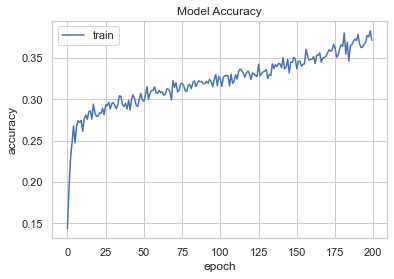

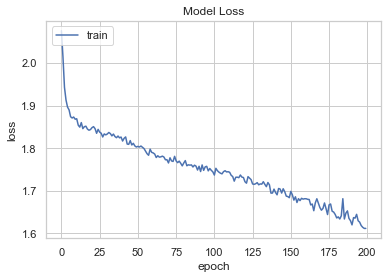

In [9]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [10]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [11]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [12]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()
# pred_df = df_drop(pred_df)

,Subject,Char_Total_Str,Char_Total_Int,Char_Init,Char_End,Current_Dwell,Interval,Press_Flight,Release_Flight,Digraph,Later_Dwell
0,adhy,q_u,17_21,17,21,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102
1,adhy,u_e,21_5,21,5,0.152102,-0.024045,0.128057,0.064835,0.216937,0.088880
2,adhy,e_l,5_12,5,12,0.088880,0.016041,0.104921,0.087948,0.176828,0.071907
3,adhy,l_l,12_12,12,12,0.071907,0.048148,0.120055,0.136069,0.207975,0.087920
4,adhy,p_i,16_9,16,9,0.159790,-0.047984,0.111806,0.087697,0.247487,0.135681


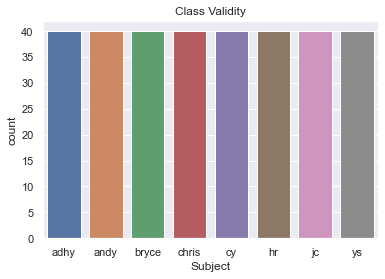

In [13]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [14]:
pred_dataset = pred_df.values
result_list = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

Y = CLASS_LIST
Y = np.asarray(Y)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

########################
# # predict all rows # #
########################
# pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# print(pred_row)

pred = []
acc = []
results = []
for _ in range(0, 320, 4):
    
    pred_row=pred_df.iloc[0+_:4+_,FEATURES_COL_NUM:]
    pred_row = pred_row.values.tolist()
    pred_arr = np.asarray(pred_row, dtype=np.float32)
    pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

    pred_proba = model.predict(pred_arr)
    pred_proba = np.sum(pred_proba, axis=0)
    pred_proba = np.reshape(pred_proba, (1, len(CLASS_LIST)))
    pred.append(lb.inverse_transform(pred_proba))
    acc.append(np.max(pred_proba, axis=1))
    results.append(result_list[_])


pred = np.asarray(pred)
acc = np.asarray(acc)
pred_results = np.column_stack((pred, acc))
pred_results = np.column_stack((results, pred_results))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=pred_results, index=None, columns=['Results', 'Prediction', 'Accuracy'])
print(df)
df.to_csv(RESULT_NAME)

   Results Prediction    Accuracy
0     adhy         jc  0.76169384
1     adhy         hr   0.7614502
2     adhy      bryce  0.77130836
3     adhy         jc  0.69711846
4     adhy       andy    1.714491
5     adhy       adhy  0.89305586
6     adhy      chris   0.9194413
7     adhy         hr  0.90733284
8     adhy       adhy  0.95306385
9     adhy         cy   1.4801369
10    andy       andy  0.95090395
11    andy       andy   1.6771164
12    andy       andy   1.1785924
13    andy         jc   0.6194993
14    andy       andy    2.037181
15    andy       andy  0.86957777
16    andy         hr  0.83613145
17    andy       andy  0.84328985
18    andy      bryce  0.90878683
19    andy       andy   1.0038157
20   bryce         cy    1.369669
21   bryce      chris    1.138555
22   bryce         ys  0.99558425
23   bryce         jc   0.9538399
24   bryce         cy    1.118736
25   bryce      bryce   1.4962287
26   bryce         jc  0.99166346
27   bryce      chris  0.90425885
28   bryce    

In [15]:
# pred_dataset = pred_df.values
# results = pred_dataset[:,CLASSES_COL_NUM]

# # # divide data into features X
# # pred_row = pred_dataset[:,3:].astype(float)

# ########################
# # # predict all rows # #
# ########################
# # pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

# #################################
# # # predict more than one row # #
# #################################
# num = 15
# start = 0 + num * 4
# end = 4 + num * 4
# pred_row=pred_df.iloc[start:end,FEATURES_COL_NUM:]
# # print(pred_row)

# ############################
# # # predict a single row # #
# ############################

# # pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

# ##################
# # # shape data # #
# ##################
# pred_row = pred_row.values.tolist()
# pred_arr = np.asarray(pred_row, dtype=np.float32)
# pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

# Y = CLASS_LIST
# Y = np.asarray(Y)
# Y = Y.reshape(-1, 1)
# lb = LabelBinarizer().fit(Y)
# Y = lb.transform(Y)

In [16]:
# ####################################
# # # get prediction and its label # #
# ####################################

# pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, len(CLASS_LIST)))

# pred = lb.inverse_transform(pred_proba)
# acc = np.max(pred_proba, axis=1)

# pred_results = np.column_stack((pred, acc))
# # pred_results = np.column_stack((results, pred_results))

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# # df = pd.DataFrame(data=pred_results, index=None, columns=['Results', 'Prediction', 'Accuracy'])
# df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
# print(df)

# df.to_csv(RESULT_NAME)

In [17]:
# pred_dataset = pred_df.values
# result_list = pred_dataset[:,CLASSES_COL_NUM]

# # # divide data into features X
# # pred_row = pred_dataset[:,3:].astype(float)

# Y = CLASS_LIST
# Y = np.asarray(Y)
# Y = Y.reshape(-1, 1)
# lb = LabelBinarizer().fit(Y)
# Y = lb.transform(Y)

# ########################
# # # predict all rows # #
# ########################
# # pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

# #################################
# # # predict more than one row # #
# #################################

# # print(pred_row)

# pred = []
# acc = []
# results = []
# for _ in range(0, 320, 4):
    
#     pred_row=pred_df.iloc[0+_:4+_,FEATURES_COL_NUM:]
#     pred_row = pred_row.values.tolist()
#     pred_arr = np.asarray(pred_row, dtype=np.float32)
#     pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

#     pred_proba = model.predict(pred_arr)
#     pred_proba = np.sum(pred_proba, axis=0)
#     pred_proba = np.reshape(pred_proba, (1, len(CLASS_LIST)))
#     pred.append(lb.inverse_transform(pred_proba))
#     acc.append(np.max(pred_proba, axis=1))
#     results.append(result_list[_])


# pred = np.asarray(pred)
# acc = np.asarray(acc)
# pred_results = np.column_stack((pred, acc))
# pred_results = np.column_stack((results, pred_results))

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# df = pd.DataFrame(data=pred_results, index=None, columns=['Results', 'Prediction', 'Accuracy'])
# print(df)
# df.to_csv(RESULT_NAME)
# ############################
# # # predict a single row # #
# ############################

# # pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

# ##################
# # # shape data # #
# ##################

